# Sentiment Analysis of Movie Reviews

In this project, I attempted to classify a series of review from Rotten Tomatoes into their respective sentiments. I took the data from a Kaggle Competition with the same aim(https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data).

The winner of the competition had an accuracy of 76% with his model.

*************************************

## Data Exploration

In [ ]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving train.tsv to train.tsv


In [ ]:
#Loading raw data
import pandas as pd
raw_train_data  = pd.read_csv('train.tsv', sep='\t')
#raw_train_data =  pd.DataFrame.from_csv('train.tsv', sep='\t', header=0)
#raw_train_data = raw_train_data.reset_index()

raw_train_data .head()

PhraseId  ...  Sentiment
0         1  ...          1
1         2  ...          2
2         3  ...          2
3         4  ...          2
4         5  ...          2

[5 rows x 4 columns]

In [ ]:
raw_train_data.sample(n=5)

PhraseId  ...  Sentiment
79121      79122  ...          1
145345    145346  ...          1
125172    125173  ...          0
24672      24673  ...          2
54472      54473  ...          3

[5 rows x 4 columns]

As we can see, the data has 4 columns,[PhraseId,SentenceId,Phrase,Sentiment]. Each sentence/review is split up into phrases and a sentiment label is attached to it. 

The sentiment label types are: 
- 0(Negative)
- 1(Somewhat negative)
- 2(Neutral)
- 3(Somewhat positive)
- 4(Positive)

In [ ]:
raw_train_data.describe()

PhraseId     SentenceId      Sentiment
count  156060.000000  156060.000000  156060.000000
mean    78030.500000    4079.732744       2.063578
std     45050.785842    2502.764394       0.893832
min         1.000000       1.000000       0.000000
25%     39015.750000    1861.750000       2.000000
50%     78030.500000    4017.000000       2.000000
75%    117045.250000    6244.000000       3.000000
max    156060.000000    8544.000000       4.000000

There are a total of 156060 data points, with the average sentiment being neutral, bordering on somewhat positive.

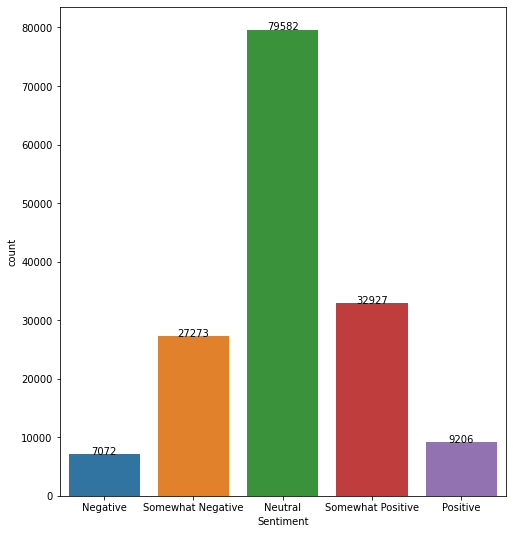

In [ ]:
plt.figure(figsize=(8,9))
ax=sns.countplot(x='Sentiment',data=raw_train_data)

labels = ['Negative','Somewhat Negative','Neutral','Somewhat Positive','Positive']
ax.set_xticklabels(labels)

for p in ax.patches:
    height = p.get_height()
    if(np.isnan(height)):
        height=0
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            height,
            ha="center")

The most frequent sentiment associated with reviews is 'neutral', whereas the least frequent is 'negative'.

In [ ]:
print("Total number of sentences: " + str(raw_train_data['SentenceId'][-1:].values))

Total number of sentences: [8544]


There are a total of 8,544 reviews, which have been split up into different phrases.

*************************************************


In [ ]:
import nltk
nltk.download('punkt')
  
from nltk.tokenize import word_tokenize

#Tokenizing the phrases
raw_train_data['Tokens'] = raw_train_data.apply(lambda row: word_tokenize(row['Phrase']), axis=1)

#Converting tokens to lower case
raw_train_data['Tokens'] = raw_train_data.apply(lambda row: map(lambda x:x.lower(),row['Tokens']),axis=1)

raw_train_data['Tokens'].head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


0    <map object at 0x7f52c346ee48>
1    <map object at 0x7f52c346eef0>
2    <map object at 0x7f52c346ef60>
3    <map object at 0x7f52c83b4048>
4    <map object at 0x7f52c83b40f0>
Name: Tokens, dtype: object

I've tokenized the phrases and converted the words into lower case. Tokenizing is the process of splitting a sentence into words(or tokens). I've also converted the tokens to all lower-case in order to prevent the model from differentiating between,say, 'Annoying' and 'annoying'.

In [ ]:
#Remove punctuation
punct = ['.',',',':','``','--','','\'s','\'','&','$','#','\'\'','`']

def punctremove(mylist):
    return [w for w in mylist if not w in punct]

raw_train_data['Tokens'] = raw_train_data.apply(lambda row: punctremove(row['Tokens']), axis=1)

I've removed punctuation from the tokens because they don't add any immediate sentiment to a sentence. Notice that I haven't removed punctuation like '!' and '?' which could add sentiment.

In [ ]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

#Lemmatizing tokens
lemmatizer = WordNetLemmatizer()

def lemmatizefunc(mylist):
    return [lemmatizer.lemmatize(w) for w in mylist]

raw_train_data['Tokens'] = raw_train_data.apply(lambda row: lemmatizefunc(row['Tokens']), axis=1)

raw_train_data['Tokens'].head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


0    [a, series, of, escapade, demonstrating, the, ...
1    [a, series, of, escapade, demonstrating, the, ...
2                                          [a, series]
3                                                  [a]
4                                             [series]
Name: Tokens, dtype: object

Lemmatizing is the process of simplifying tokens down to their base word. For example, the word 'tyres' is simplified down to 'tyre'. It is different from another process, stemming, in the way that lemmatizing leads to a simplification to an actual word, whereas stemming can simplify a word down to something which isn't an actual word. 

Lemmatizing will largely help in reducing the large vocabulary pool, and helping word2vec create a more robust model.

In [ ]:
#Building a dictionary
word_list = []
for index,value in raw_train_data['Tokens'].iteritems():
    word_list.extend(value)

vocab = set(word_list)

vocab_set = sorted(vocab)

In [ ]:
#Creating dictionary containing frequency of words
vocab_freq = dict()

for value in vocab_set:
    vocab_freq[value]=0
    
for index,item in raw_train_data['Tokens'].iteritems():
    for word in item:
        vocab_freq[word] = vocab_freq[word] + 1
        
vocab_freq

{'!': 248,
 "'30s": 16,
 "'40s": 15,
 "'50s": 34,
 "'53": 7,
 "'60s": 51,
 "'70s": 68,
 "'80s": 13,
 "'90s": 13,
 "'d": 293,
 "'em": 72,
 "'ll": 484,
 "'m": 211,
 "'n": 9,
 "'re": 812,
 "'til": 8,
 "'ve": 563,
 '+': 11,
 '-': 761,
 '-lrb-': 2098,
 '-rrb-': 2438,
 '...': 1884,
 '1': 37,
 '1.2': 13,
 '1.8': 17,
 '10': 117,
 '10,000': 12,
 '10-course': 7,
 '10-year': 15,
 '10-year-old': 10,
 '100': 48,
 '100-minute': 15,
 '100-year': 7,
 '101': 42,
 '102-minute': 16,
 '103-minute': 15,
 '104': 15,
 '105': 12,
 '10th': 5,
 '10th-grade': 11,
 '11': 38,
 '110': 17,
 '112-minute': 9,
 '12': 14,
 '12-year-old': 31,
 '120': 7,
 '127': 10,
 '129-minute': 9,
 '12th': 10,
 '13': 39,
 '13th': 13,
 '14-year-old': 13,
 '140': 8,
 '146': 15,
 '15': 67,
 '15-year': 11,
 '15th': 8,
 '163': 13,
 '168-minute': 8,
 '170': 19,
 '1790': 12,
 '18': 15,
 '18-year-old': 24,
 '1899': 6,
 '19': 5,
 '1915': 16,
 '1920': 16,
 '1930s': 7,
 '1933': 9,
 '1937': 10,
 '1938': 12,
 '1940s': 16,
 '1950': 10,
 '1950s': 28,

In [ ]:
import operator

print("Total number of unique words: " + str(len(vocab_set)))
sorted_vocab_freq = list(reversed(sorted(vocab_freq.items(), key=operator.itemgetter(1))))
print("Top 100 most frequently used words: " + str(sorted_vocab_freq[:100]))

Total number of unique words: 15179
Top 100 most frequently used words: [('the', 51220), ('a', 44748), ('of', 32308), ('and', 31763), ('to', 22448), ('it', 18728), ('in', 13754), ('is', 13447), ('that', 12327), ('with', 7750), ('film', 7668), ('for', 7417), ('movie', 7250), ('an', 6479), ('this', 5677), ('but', 5126), ('be', 4977), ('you', 4827), ('on', 4730), ("n't", 3970), ('by', 3918), ('more', 3906), ('his', 3827), ('one', 3783), ('about', 3682), ('not', 3562), ('at', 3550), ('or', 3472), ('from', 3462), ('than', 3458), ('all', 3201), ('have', 3134), ('like', 3092), ('are', 3059), ('ha', 2950), ('character', 2850), ('story', 2831), ('so', 2644), ('-rrb-', 2438), ('make', 2415), ('out', 2380), ('who', 2359), ('time', 2293), ('most', 2227), ('into', 2163), ('too', 2143), ('up', 2104), ('-lrb-', 2098), ('good', 2066), ('if', 1979), ('comedy', 1939), ('what', 1899), ('their', 1899), ('...', 1884), ('much', 1862), ('life', 1862), ('no', 1801), ('can', 1769), ('i', 1768), ('way', 1767), 

Words like 'film' and 'story' are commonly used in movie reviews. It is also interesting to note that words like 'comedy' and 'funny' are commonly used. This could suggest that many of the reviews are done on comedic movies. However, there can be other contexts which those words could be placed in, and which could suggest otherwise. An example would be '....a comedy of errors...' which would suggest negative sentiment. 

In [ ]:
sentences = []
sentid = 0
sentlabels = []
for index,row in raw_train_data.iterrows():
    if (sentid!=row['SentenceId']):
        sentid = row['SentenceId']
        sentlabels.append(row['Sentiment'])
        sentences.append(row['Tokens'])
sentences

[['a',
  'series',
  'of',
  'escapade',
  'demonstrating',
  'the',
  'adage',
  'that',
  'what',
  'is',
  'good',
  'for',
  'the',
  'goose',
  'is',
  'also',
  'good',
  'for',
  'the',
  'gander',
  'some',
  'of',
  'which',
  'occasionally',
  'amuses',
  'but',
  'none',
  'of',
  'which',
  'amount',
  'to',
  'much',
  'of',
  'a',
  'story'],
 ['this',
  'quiet',
  'introspective',
  'and',
  'entertaining',
  'independent',
  'is',
  'worth',
  'seeking'],
 ['even',
  'fan',
  'of',
  'ismail',
  'merchant',
  'work',
  'i',
  'suspect',
  'would',
  'have',
  'a',
  'hard',
  'time',
  'sitting',
  'through',
  'this',
  'one'],
 ['a',
  'positively',
  'thrilling',
  'combination',
  'of',
  'ethnography',
  'and',
  'all',
  'the',
  'intrigue',
  'betrayal',
  'deceit',
  'and',
  'murder',
  'of',
  'a',
  'shakespearean',
  'tragedy',
  'or',
  'a',
  'juicy',
  'soap',
  'opera'],
 ['aggressive', 'self-glorification', 'and', 'a', 'manipulative', 'whitewash'],
 ['a

*************************************

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(np.array(raw_train_data['Tokens']),
                np.array(raw_train_data['Sentiment']), test_size=0.5)

Training set: 80% Validation set: 20%

In [ ]:
from gensim.models.doc2vec import LabeledSentence

def labelize(phrase, label_type):
    labelized = []
    for i,v in enumerate(phrase):
        label = '%s:%s'%(label_type,i)
        labelized.append(LabeledSentence(v, [label]))
    return labelized

x_train = labelize(x_train, 'TRAIN')
x_test = labelize(x_test, 'TEST')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  import sys


Before feeding the tokens into a Word2Vec model, I've labeled the tokens according to whether they belong to the training or testing/validation set, and which phrase they belong to(a.k.a their PhraseId). I've done this using the LabeledSentence feature from doc2vec.

The format of a LabeledSentence can be observed below:

In [ ]:
x_train[2]

LabeledSentence(words=['the', 'more', 'detail'], tags=['TRAIN:2'])

In [ ]:
from gensim.models import Word2Vec

phrase_w2v = Word2Vec(size=100,min_count=15)
phrase_w2v.build_vocab([x.words for x in x_train])
phrase_w2v.train([x.words for x in x_train],total_examples = phrase_w2v.corpus_count,epochs=phrase_w2v.iter)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """


(1666565, 2580060)

Using Word2Vec, I created and trained a model on the tokens of the training data. In a gist, Word2Vec creates a neural network which converts tokens into numerical vectors. These vectors(also called embeddings) can be fed into a neural network and be used to classify based on sentiment. The sum and/or difference between these vectors carry great meaning, which I've demonstrated below. Embeddings whose associated tokens carry similar meaning are generally clustered closer to each other, and vice versa. 

I assigned the size in the model as 150, which basically defines the degrees of freedom, or roughly, the number of nodes in the model. Also, words fed into the model whose frequency in the data is less than 10 is ignored.

The embedding for the word 'nice' can be observed below:

In [ ]:
phrase_w2v['nice']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 0.03832083, -0.13957286,  0.36822593, -0.05185975, -0.14957201,
        0.19880782, -0.14864744, -0.06639016,  0.46032262, -0.18082903,
        0.16005363,  0.14395353,  0.01695093, -0.09158953, -0.04111326,
       -0.20141572, -0.3299297 , -0.01298925, -0.10809585,  0.45324045,
        0.12316242,  0.23965959,  0.02728207, -0.09131481,  0.36583006,
        0.06352263,  0.03432767,  0.04698488,  0.4158616 ,  0.10725408,
       -0.362229  ,  0.15676916,  0.02497985, -0.28791925, -0.33927542,
       -0.06345979, -0.39820552,  0.02319587, -0.05778526, -0.09628297,
        0.03645907, -0.05121053, -0.2250105 ,  0.04345375, -0.35082892,
       -0.24337368,  0.10374279,  0.02427571,  0.15206933,  0.13155787,
        0.02555129,  0.21027413, -0.05765846, -0.15355803, -0.19258611,
        0.04701471,  0.35809264,  0.12969115,  0.09166272,  0.01494594,
       -0.24067295, -0.28443682,  0.23466355, -0.14182526,  0.2777089 ,
        0.25526446,  0.21974304, -0.2112375 , -0.18376124, -0.09

In [ ]:
#A fun demonstration of the power of Word2Vec
print("Words similar to boring: " + str(phrase_w2v.most_similar('boring')))
print("Words similar to fun: " + str(phrase_w2v.most_similar('fun')))
print("Words similar to amazing: " + str(phrase_w2v.most_similar('amazing')))
print("Words similar to exciting: " + str(phrase_w2v.most_similar('exciting')))

Words similar to boring: [('seriously', 0.966054379940033), ('saying', 0.9649759531021118), ('awful', 0.9618232250213623), ('resolution', 0.9599706530570984), ('sympathy', 0.9597089290618896), ('obviously', 0.9594776034355164), ('canadian', 0.9585323333740234), ('record', 0.9585206508636475), ('clear', 0.9573871493339539), ('stupid', 0.9570516347885132)]
Words similar to fun: [('either', 0.8549295663833618), ('simply', 0.8464922308921814), ('bit', 0.8439578413963318), ('intention', 0.8299275636672974), ('nothing', 0.8279191255569458), ('problem', 0.8278021812438965), ('really', 0.8270421028137207), ('few', 0.8241307735443115), ('documentary', 0.821227490901947), ('idea', 0.8202018737792969)]
Words similar to amazing: [('king', 0.9917287826538086), ('fierce', 0.9896177053451538), ('represents', 0.9887166619300842), ('bruckheimer', 0.9878882765769958), ('rage', 0.9878693222999573), ('joel', 0.9877719879150391), ('slack', 0.98753821849823), ('tiresome', 0.98746657371521), ('ramsay', 0.987

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dis

We can see that words similar to boring can be detected using the model. For example, it is surprising to observe that the model is able to recognize that boring and tedious are similar, amazing and surreal are similar, etc. Of course there are some weird exceptions, but we can see that some words bear a certain resemblance.

In [ ]:
from sklearn.manifold import TSNE

plt.figure(figsize=(9,9))

X = phrase_w2v[phrase_w2v.wv.vocab]

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1])

plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


A tSNE graph, or a t-distributed stochastic neighbor embedding graph, maps all the embeddings in the model down to a two dimensional space. It can be observed that there are certain clusterings of different embeddings. The embeddings which are closer together(smaller Euclidean distance) bear more similarity in meaning to one another.

***********************************

## Data Preprocessing

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=10)
matrix = vectorizer.fit_transform([x.words for x in x_train])
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
print('vocab size :', len(tfidf))

The first step of preprocessing is to convert these word vectors into phrase vectors. There are a few methods of doing this(using simple sum of vectors, average of vectors, feeding the vectors into an LSTM network,etc.). The method I've gone with is a weighted average of word embeddings. The weights of each word embedding are its TF-IDF value.

The TF-IDF (Term Frequency,Inverse Document Frequency) method of weighting has a simple intuition. If a word appears more in a phrase(term frequency), it is important for the sentiment, however, if the word appears more overall across all phrases(document frequency), it should be given less importance. Combining these two, a TF-IDF weight can be assigned to all word vectors, and a weighted average can be carried out.

In [ ]:
def buildPhraseVector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += phrase_w2v[word].reshape((1, size)) * tfidf[word]
            count += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

I've created a weighting average function in the above step to generate phrase vectors.

In [ ]:
from sklearn.preprocessing import scale
train_vecs_w2v = np.concatenate([buildPhraseVector(z, 100) for z in map(lambda x: x.words, x_train)])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([buildPhraseVector(z, 100) for z in map(lambda x: x.words, x_test)])
test_vecs_w2v = scale(test_vecs_w2v)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


I've scaled the phrase vectors down to allow for smooth training.

In [ ]:
import keras

# One-hot encoding the labels
num_classes = 5

y_train = keras.utils.to_categorical(y_train, num_classes)
print(y_train.shape)
y_train = (y_train == 1).astype('float32')
y_train = y_train.reshape(-1, 1)

# One-hot encoding the labels
num_classes = 5
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_train.shape)
print(y_test.shape)

(390150, 5)
(1950750, 1)
(78030, 5, 5)


I've one-hot encoded the labels to be used in the Keras neural network.

## Model Selection and Training

The following model that I've created was a result of intuitive trial-and-error. I've created a fully-connected neural network with appropriate dropouts to prevent overfitting. My intuition was as follows:
- The more the degrees of freedom in the Word2Vec model(or the larger the word vector), the more number of nodes(the more deeper) the neural net.
- When moving from one hidden layer to the next, try to maintain a steady drop in nodes.(e.g. if layer 1 has 512 nodes, layer 2 should have 256 rather than 16 nodes)
- Assign dropout to only those layers with a larger number of nodes(below 128). Assigning dropout to layers with smaller number of nodes will only create improper training of that layer.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from keras.callbacks import ModelCheckpoint

model = Sequential()


model.add(Dense(256, activation='relu',input_dim=100))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu',input_dim=100))
model.add(Dense(19, activation='sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 256)               25856     
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_34 (Dense)             (None, 19)                2451      
_________________________________________________________________
dropout_16 (Dropout)         (None, 19)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 64)                1280      
_________________________________________________________________
dense_36 (Dense)             (None, 5)                

In [ ]:
# Compiling the model
#model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['categorical_accuracy'])
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['categorical_accuracy'])

Compiled the model with the loss as categorical cross-entropy since we are doing multi-class classification.

In [ ]:
checkpointer = ModelCheckpoint(filepath='weights.best.hdf5', verbose=1, save_best_only=True)

I've saved the best weights with respect to the validation accuracy using ModelCheckpoint.

In [ ]:
# Running and evaluating the model
model.fit(train_vecs_w2v, y_train, epochs=20, batch_size=32,validation_data=(test_vecs_w2v,y_test), callbacks=[checkpointer],verbose=1)

ValueError: ignored

## Model Evaluation

In [ ]:
score = model.evaluate(test_vecs_w2v, y_test, batch_size=128, verbose=2)
print(score[1])

ValueError: ignored

The categorical accuracy of 56.7% that I achieved was after a lot of testing of different models. The accuracy is not as high as I expected it to be. However, my intuition was sound and it allowed me to achieve the best accuracy despite the limitations of my approach.

## Conclusions

The model does a decent job of multi-class classification, but there is still a whole lot of room for improvement.

The limitations of my approach were:
- I used an averaging method to generate a phrase vector. A much more effective way of doing so would be to use an LSTM Network and feed the word vectors into it.
- The data itself was not adequate for my method to work well. Total number of sentences(not phrases) were 8544, which is hardly enough to train a robust word2vec model. 
- I might not have done sufficient pre-processing. I had also tried removing stop words(Common words like 'a','the',etc.) and then testing the model, but it turns out, there is a very frustrating tradeoff between boosting the effectiveness of the word2vec model, and boosting the effectiveness of the Keras neural network. Removing the stop-words would have made classification much more accurate, but it led to a loss in context, leading to a drop in accuracy for the word2vec model.
- I did not incorporate the use of any recurrent node network(RNN,LSTM,GRU) for classification. A memory model may have been more effective in classification, given that it has a capability for remembering previous input.